<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/LSTM_Bidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM Bidirectional

#### Pobranie danych

In [1]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 102MB/s]


In [2]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [4]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [5]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### `LabelEncoder` oraz `to_categorical`

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
data_set_train["labelencoder"] = labelencoder.fit_transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

,clean_text,label,labelencoder
0,find cinema nearest for films,SearchScreeningEvent,6
1,give the current series two stars,RateBook,4
2,find the good girl at movie house,SearchScreeningEvent,6
3,please make reservations for three at kosher t...,BookRestaurant,1
4,what is the forecast for here one second from now,GetWeather,2


In [7]:
dummy_y.shape

(13784, 7)

In [8]:
id_intention = 6
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  BookRestaurant
LabelEncoder -  1

to_categorical -  [0. 1. 0. 0. 0. 0. 0.]

return to LabelEncoder -  1
return to Label -  ['BookRestaurant']


#### Zdefiniowanie X i y

In [9]:
X = data_set_train["clean_text"]
y = dummy_y

In [10]:
X.shape, y.shape

((13784,), (13784, 7))

#### Podział zbioru 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

#### `Tokenizer` i `pad_sequences`

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 13
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

#### Model

In [15]:
from keras.layers import LSTM, Dense

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

`Bidirectional` / `dwukierunkowe warstwy rekurencyjne`

warstwy przedstawiające te same informacje w sieci rekurencyjnej, ale robiące to na różne sposoby; rozwiązanie to zwiększa dokładność i rozwiązuje problemy z ginięciem informacji

In [16]:
from keras.layers import Bidirectional

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  
model.add(Bidirectional(LSTM(128)))
model.add(Dense(7, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}") 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 100)           976800    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 7)                 1799      
Total params: 1,213,095
Trainable params: 1,213,095
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
138/138 [==============================] - 14s 79ms/step - loss: 1.1999 - accuracy: 0.5964 - val_loss: 0.1123 - val_accuracy: 0.9624
Epoch 2/20
138/138 [==============================] - 10s 72ms/step - loss: 0.0563 - accuracy: 0.9834 - val_loss: 0.0829 - val_accuracy: 0.9742
Epoch 3/20
138/138 [==============================] - 10s 71ms/step - loss: 0.0238 

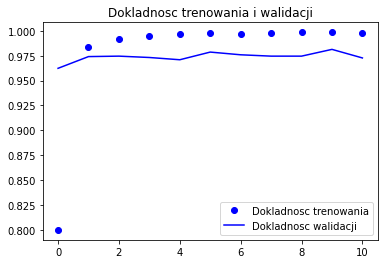

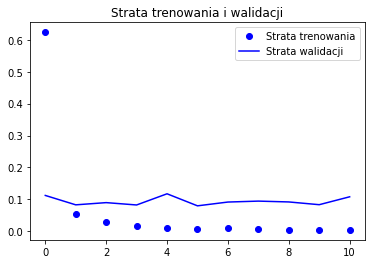

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

#### Predykcja na zbiorze validacyjnym

In [19]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[ 15,  42,  50, ...,   0,   0,   0],
       [241, 177,  21, ...,   0,   0,   0],
       [ 15,   8,   1, ...,   2, 174, 997],
       ...,
       [ 28,   1,  84, ...,   0,   0,   0],
       [ 15,   8,   1, ...,   0,   0,   0],
       [ 45,  40,   4, ...,   0,   0,   0]], dtype=int32)

In [20]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [21]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 13), (700,))

In [22]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [23]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [24]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.97
F1_score: 0.97
                      precision    recall  f1-score   support

       AddToPlaylist       0.97      1.00      0.99       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       1.00      0.97      0.98       100
           PlayMusic       1.00      0.94      0.97       100
            RateBook       0.99      0.98      0.98       100
  SearchCreativeWork       0.89      0.99      0.94       100
SearchScreeningEvent       0.98      0.93      0.95       100

            accuracy                           0.97       700
           macro avg       0.97      0.97      0.97       700
        weighted avg       0.97      0.97      0.97       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

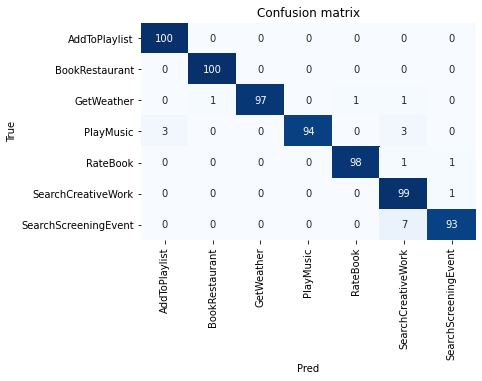

In [26]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [27]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[153, 201, 557, 568, 587, 648, 689]


In [28]:
for i in indexes:
  print(f"----------------------------\nTekst komendy:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda:\n{data_set_valid['clean_text'][i]}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy:
i want to see I Dream of Jeanie in a movie theatre
Oczyszczona komenda:
want to see dream of jeanie in movie theatre
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
is We Are Northern Lights playing in any movie theatre
Oczyszczona komenda:
is we are northern lights playing in any movie theatre
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Shattered Image.
Oczyszczona komenda:
want to see shattered image
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
Can you check the timings for Super Sweet 16: The Movie?
Oczyszczona komenda:
can you check the timings for super sweet the movie
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
Is Any Which W

Wnioski:
> 